Hướng dẫn cài đặt transformers từ [Annotated Transformer](http://nlp.seas.harvard.edu/annotated-transformer/)


In [ ]:
# Cài đặt thư viện
!pip install -q torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair GPUtil folium==0.2.1

# Tải dữ liệu cho tokenizer
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

2023-09-28 09:00:52.538804: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 09:00:55.275313: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
DEPRECATION: https://github.com/explosion/spacy-models/releases/download/de_core_news_sm-3.2.0/de_core_news_sm-3.2.0-py3-none-any.whl#egg=de_core_news_sm==3.2.0 contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 42.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package 

In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

# Background: Đây là mô hình được trình bày trong bài báo [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
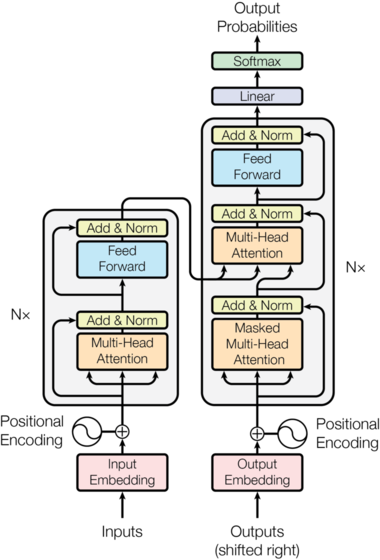

# Kiến trúc tổng quan của Transformer

In [ ]:
class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):


    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

# Ví dụ của [Softmax và LogSoftMax]("https://medium.com/@AbhiramiVS/softmax-vs-logsoftmax-eb94254445a2").

In [ ]:
input = torch.rand(3,3)
print(f"input = {input}")
SM = nn.Softmax(dim=1)
LSM = nn.LogSoftmax(dim=1)
print(f"Softmax(input) = {SM(input)}")
print(f"LogSoftmax(input) = {LSM(input)}")
print(f"Log(Softmax)) = {torch.log(SM(input))}")

input = tensor([[0.4352, 0.3408, 0.4691],
        [0.4082, 0.0220, 0.7462],
        [0.5101, 0.1934, 0.6814]])
Softmax(input) = tensor([[0.3396, 0.3090, 0.3514],
        [0.3245, 0.2205, 0.4550],
        [0.3430, 0.2499, 0.4071]])
LogSoftmax(input) = tensor([[-1.0799, -1.1743, -1.0460],
        [-1.1255, -1.5117, -0.7875],
        [-1.0700, -1.3867, -0.8987]])
Log(Softmax)) = tensor([[-1.0799, -1.1743, -1.0460],
        [-1.1255, -1.5117, -0.7875],
        [-1.0700, -1.3867, -0.8987]])


# Ví dụ của một lớp [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)


In [ ]:
# Tạo dữ liệu
data = [[1., 2., 3.], [4., 5., 6.], [7.,8.,9.]]

# Tạo ma trận input từ dữ liệu
input = torch.tensor(data) # input matrix

# Tạo một lớp ẩn cho dữ liệu
transform = nn.Linear(3,3)

# Áp dụng lớp ẩn cho dữ liệu
output = transform(input)
print(f"input = {input}")
print(f"output size = {output.size}")
print(f"output = {output}")
print(f"transform.weight = {transform.weight}")
print(f"transform.bias = {transform.bias}")
print(f"computation check = {torch.matmul(input, torch.t(transform.weight)) + transform.bias}")


transform.weight = nn.Parameter(output)
transform.bias = nn.Parameter(torch.tensor([[0.5, 0.5, 0.5]]))
new_output = transform(output)
print(f"transform.weight = {transform.weight}")
print(f"transform.bias = {transform.bias}")

print(f"new_output = {new_output}")
print(f"computation check = {torch.matmul(output, torch.t(transform.weight)) + transform.bias}")
print(f"transform.forward(output) = {transform.forward(output)}")



input = tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
output size = <built-in method size of Tensor object at 0x7c7305c46020>
output = tensor([[ 1.1282,  2.1966, -1.1664],
        [ 4.0718,  5.2461, -3.2772],
        [ 7.0153,  8.2956, -5.3880]], grad_fn=<AddmmBackward0>)
transform.weight = Parameter containing:
tensor([[ 0.5097,  0.3117,  0.1598],
        [ 0.4435,  0.1193,  0.4537],
        [-0.1852, -0.1214, -0.3970]], requires_grad=True)
transform.bias = Parameter containing:
tensor([-0.4842,  0.1534,  0.4527], requires_grad=True)
computation check = tensor([[ 1.1282,  2.1966, -1.1664],
        [ 4.0718,  5.2461, -3.2772],
        [ 7.0153,  8.2956, -5.3880]], grad_fn=<AddBackward0>)
transform.weight = Parameter containing:
tensor([[ 1.1282,  2.1966, -1.1664],
        [ 4.0718,  5.2461, -3.2772],
        [ 7.0153,  8.2956, -5.3880]], requires_grad=True)
transform.bias = Parameter containing:
tensor([[0.5000, 0.5000, 0.5000]], requires_grad=True)
new_output = te

In [ ]:
def clones(module, N):
    "Tạo ra N module giống hệt nhau"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Encoder là tập hợp của N lớp"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):

        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

# Bắt đầu với Layer Normalization

Tạo một kết nối residual giữa 2 lớp con theo sau đó là 1 lớp normalization.


Residual connections paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

Layer normalization paper: [Layer Normalization](https://arxiv.org/abs/1607.06450)

Batch normalization paper: [Batch Normalizaton](https://arxiv.org/abs/1502.03167)


In [ ]:
class LayerNorm(nn.Module):
    "Tạo 1 lớp layernorm"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


In [ ]:
class SublayerConnection(nn.Module):

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Kết nối bằng residual connection."
        return x + self.dropout(sublayer(self.norm(x)))

Mỗi lớp gồm hai lớp con. Lớp thứ nhất là multi-head self-attention. Lớp thứ 2 là mạng truyền thẳng (fully connected feed-forward network)

In [ ]:
class EncoderLayer(nn.Module):


    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

Decoder gồm $N=6$ lớp giống hệt nhau.

In [ ]:
class Decoder(nn.Module):

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [ ]:
class DecoderLayer(nn.Module):


    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):

        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

Sử dụng mask để khi dự đoán từ ở vị trí $i$ ta chỉ sử dụng thông tin của các vị trí trước $i$

In [ ]:
def subsequent_mask(size):

    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [ ]:
max_pos = 10
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(max_pos)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(max_pos)
            for x in range(max_pos)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

# Attention



In [ ]:
def attention(query, key, value, mask=None, dropout=None):

    d_k = query.size(-1)

    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

# Multi-head Attention
Multi-head Attention giúp mô hình tập hợp thông tin từ nhiều biểu diễn khác nhau từ nhiều vị trí khác nhau.




In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:

            mask = mask.unsqueeze(1)
        nbatches = query.size(0)


        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]


        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )


        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

Positional Encoding để mô hình có thông tin về vị trí

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [ ]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0,  0,  2,  0,  3,  5, 10,  0,  5, 10]])
Example Untrained Model Prediction: tensor([[0, 8, 8, 8, 8, 8, 8, 4, 8, 4]])
Example Untrained Model Prediction: tensor([[ 0,  8,  1,  4,  7, 10,  1,  4,  7, 10]])
Example Untrained Model Prediction: tensor([[0, 4, 1, 4, 1, 4, 1, 4, 0, 7]])
Example Untrained Model Prediction: tensor([[ 0,  6, 10, 10, 10, 10, 10,  3,  8,  8]])
Example Untrained Model Prediction: tensor([[ 0, 10,  2,  1, 10,  2,  1,  2,  1,  9]])
Example Untrained Model Prediction: tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Example Untrained Model Prediction: tensor([[ 0,  7,  6, 10,  5,  7,  5,  7,  5,  7]])
Example Untrained Model Prediction: tensor([[0, 6, 5, 9, 0, 6, 5, 3, 1, 3]])
Example Untrained Model Prediction: tensor([[0, 1, 4, 4, 4, 1, 4, 1, 4, 8]])


In [ ]:
class Batch:

    def __init__(self, src, tgt=None, pad=2):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Số bước ở epoch hiện tại
    accum_step: int = 0  # Số lượng lần đại hàm
    samples: int = 0  # Số lượng mẫu
    tokens: int = 0  # Số lượng token

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Huấn luyện 1 epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

In [ ]:
def rate(step, model_size, factor, warmup):
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
def example_learning_schedule():
    opts = [
        [512, 1, 4000],
        [512, 1, 8000],
        [256, 1, 4000],
    ]

    dummy_model = torch.nn.Linear(1, 1)
    learning_rates = []


    for idx, example in enumerate(opts):

        optimizer = torch.optim.Adam(
            dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
        )
        lr_scheduler = LambdaLR(
            optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
        )
        tmp = []

        for step in range(20000):
            tmp.append(optimizer.param_groups[0]["lr"])
            optimizer.step()
            lr_scheduler.step()
        learning_rates.append(tmp)

    learning_rates = torch.tensor(learning_rates)


    alt.data_transformers.disable_max_rows()

    opts_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Learning Rate": learning_rates[warmup_idx, :],
                    "model_size:warmup": ["512:4000", "512:8000", "256:4000"][
                        warmup_idx
                    ],
                    "step": range(20000),
                }
            )
            for warmup_idx in [0, 1, 2]
        ]
    )

    return (
        alt.Chart(opts_data)
        .mark_line()
        .properties(width=600)
        .encode(x="step", y="Learning Rate", color="model_size:warmup:N")
        .interactive()
    )


example_learning_schedule()

Output hidden; open in https://colab.research.google.com to view.

# Regularization



In [ ]:
class LabelSmoothing(nn.Module):

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

In [ ]:
def example_label_smoothing():
    crit = LabelSmoothing(5, 0, 0.4)
    predict = torch.FloatTensor(
        [
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
            [0, 0.2, 0.7, 0.1, 0],
        ]
    )
    crit(x=predict.log(), target=torch.LongTensor([2, 1, 0, 3, 3]))
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "target distribution": crit.true_dist[x, y].flatten(),
                    "columns": y,
                    "rows": x,
                }
            )
            for y in range(5)
            for x in range(5)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect(color="Blue", opacity=1)
        .properties(height=200, width=200)
        .encode(
            alt.X("columns:O", title=None),
            alt.Y("rows:O", title=None),
            alt.Color(
                "target distribution:Q", scale=alt.Scale(scheme="viridis")
            ),
        )
        .interactive()
    )

show_example(example_label_smoothing)


alt.Chart(...)

In [ ]:
def loss(x, crit):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d]])
    return crit(predict.log(), torch.LongTensor([1])).data


def penalization_visualization():
    crit = LabelSmoothing(5, 0, 0.1)
    loss_data = pd.DataFrame(
        {
            "Loss": [loss(x, crit) for x in range(1, 100)],
            "Steps": list(range(99)),
        }
    ).astype("float")

    return (
        alt.Chart(loss_data)
        .mark_line()
        .properties(width=350)
        .encode(
            x="Steps",
            y="Loss",
        )
        .interactive()
    )


show_example(penalization_visualization)

alt.Chart(...)

First example:  The copy-task or identity function.

In [ ]:
def data_gen(V, batch_size, nbatches):

    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

In [ ]:
class SimpleLossCompute:

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

Sử dụng cách tham lam (có thể sử dụng cách khác như beam search)

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [ ]:
def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=2)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 80
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 1, 2, 3, 4, 5]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


# execute_example(example_simple_model)

# Part 3: Ứng dụng cho bài toán dịch

Sử dụng bộ dữ liệu [Multi30K](https://www.statmt.org/europarl/) để thử nghiệm dịch Đức-Anh.


In [1]:
# Tải dữ liệu
!wget https://www.statmt.org/europarl/v7/de-en.tgz
# Giải nén dữ liệu
!tar -xf de-en.tgz

--2023-09-28 13:25:52--  https://www.statmt.org/europarl/v7/de-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197785698 (189M) [application/x-gzip]
Saving to: ‘de-en.tgz’

de-en.tgz           100%[===================>] 188.62M  4.03MB/s    in 47s     

2023-09-28 13:26:39 (3.99 MB/s) - ‘de-en.tgz’ saved [197785698/197785698]



In [2]:
# Tải dữ liệu
my_file_en = "europarl-v7.de-en.en"
my_file_de = "europarl-v7.de-en.de"

size_train = 100000
size_val = 4000
size_test = 4000

train = []
val = []
test = []

de_list = []
en_list = []

count = 0;
with open(my_file_de, encoding="utf8") as fp:
  for line in fp:
    de_list.append(line)
    if count >= (size_train + size_val + size_test - 1):
      break
    count += 1

count = 0;
with open(my_file_en, encoding="utf8") as fp:
  for line in fp:
    en_list.append(line)
    if count > (size_train + size_val + size_test - 1):
      break
    count += 1

dataset = list(zip(de_list, en_list))
train = dataset[:size_train]
val = dataset[size_train:size_train+size_val]
test = dataset[size_train+size_val:size_train+size_val+size_test]

print(len(train), len(val), len(test))

100000 4000 4000


In [ ]:
# Tải tokenizer cho 2 ngôn ngữ

def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [ ]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [ ]:
def build_vocabulary(spacy_de, spacy_en, train, val, test):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")

    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")

    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt

def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en, train, val, test)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Finished.
Vocabulary sizes:
41372
21549


In [ ]:
def collate_batch(
    batch,
    src_pipeline,
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # token id của <s>
    eos_id = torch.tensor([1], device=device)  # token id của </s>
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(

            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [ ]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
    is_distributed=True,
):

    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = train, val, test

    train_iter_map = to_map_style_dataset(
        train_iter
    )
    train_sampler = (
        DistributedSampler(train_iter_map) if is_distributed else None
    )
    valid_iter_map = to_map_style_dataset(valid_iter)
    valid_sampler = (
        DistributedSampler(valid_iter_map) if is_distributed else None
    )

    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        sampler=train_sampler,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle=(valid_sampler is None),
        sampler=valid_sampler,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

In [ ]:
def train_worker(
    gpu,
    ngpus_per_node,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    config,
    is_distributed=False,
):
    print(f"Train worker process using GPU: {gpu} for training", flush=True)
    torch.cuda.set_device(gpu)

    pad_idx = vocab_tgt["<blank>"]
    d_model = 512
    print("Got to this point(1)!!!")
    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    print("Got to this point(2)!!!")
    model.cuda(gpu)
    print("Got to this point(3)!!!")
    module = model
    print("Got to this point(4)!!!")
    is_main_process = True
    if is_distributed:
        dist.init_process_group(
            "nccl", init_method="env://", rank=gpu, world_size=ngpus_per_node
        )
        model = DDP(model, device_ids=[gpu])
        module = model.module
        is_main_process = gpu == 0

    criterion = LabelSmoothing(
        size=len(vocab_tgt), padding_idx=pad_idx, smoothing=0.1
    )
    criterion.cuda(gpu)
    print("Got to this point(5)!!!")

    train_dataloader, valid_dataloader = create_dataloaders(
        gpu,
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=config["batch_size"] // ngpus_per_node,
        max_padding=config["max_padding"],
        is_distributed=is_distributed,
    )
    print("Got to this point(6)!!!")
    optimizer = torch.optim.Adam(
        model.parameters(), lr=config["base_lr"], betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, d_model, factor=1, warmup=config["warmup"]
        ),
    )
    train_state = TrainState()
    for epoch in range(config["num_epochs"]):
        if is_distributed:
            train_dataloader.sampler.set_epoch(epoch)
            valid_dataloader.sampler.set_epoch(epoch)

        model.train()
        print(f"[GPU{gpu}] Epoch {epoch} Training ====", flush=True)
        _, train_state = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in train_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train+log",
            accum_iter=config["accum_iter"],
            train_state=train_state,
        )

        GPUtil.showUtilization()
        if is_main_process:
            file_path = "%s%.2d.pt" % (config["file_prefix"], epoch)
            torch.save(module.state_dict(), file_path)
        torch.cuda.empty_cache()

        print(f"[GPU{gpu}] Epoch {epoch} Validation ====", flush=True)
        model.eval()
        sloss = run_epoch(
            (Batch(b[0], b[1], pad_idx) for b in valid_dataloader),
            model,
            SimpleLossCompute(module.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )
        print(sloss)
        torch.cuda.empty_cache()

    if is_main_process:
        file_path = "%sfinal.pt" % config["file_prefix"]
        torch.save(module.state_dict(), file_path)
def train_distributed_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    from the_annotated_transformer import train_worker

    ngpus = torch.cuda.device_count()
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12356"
    print(f"Number of GPUs detected: {ngpus}")
    print("Spawning training processes ...")
    mp.spawn(
        train_worker,
        nprocs=ngpus,
        args=(ngpus, vocab_src, vocab_tgt, spacy_de, spacy_en, config, True),
    )


def train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config):
    if config["distributed"]:
        train_distributed_model(
            vocab_src, vocab_tgt, spacy_de, spacy_en, config
        )
    else:
        train_worker(
            0, 1, vocab_src, vocab_tgt, spacy_de, spacy_en, config, False
        )


def load_trained_model():
    config = {
        "batch_size": 64,
        "distributed": False,
        "num_epochs": 1,
        "accum_iter": 10,
        "base_lr": 1.0,
        "max_padding": 72,
        "warmup": 3000,
        "file_prefix": "multi30k_model_",
    }
    model_path = "multi30k_model_final.pt"
    if not exists(model_path):
        train_model(vocab_src, vocab_tgt, spacy_de, spacy_en, config)

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(torch.load("multi30k_model_final.pt"))
    return model


if is_interactive_notebook():
    model = load_trained_model()

Train worker process using GPU: 0 for training
Got to this point(1)!!!
Got to this point(2)!!!
Got to this point(3)!!!
Got to this point(4)!!!
Got to this point(5)!!!
Got to this point(6)!!!
[GPU0] Epoch 0 Training ====
Epoch Step:      1 | Accumulation Step:   1 | Loss:   8.69 | Tokens / Sec:  2436.4 | Learning Rate: 5.4e-07
Epoch Step:     41 | Accumulation Step:   5 | Loss:   8.59 | Tokens / Sec:  2950.4 | Learning Rate: 1.1e-05
Epoch Step:     81 | Accumulation Step:   9 | Loss:   8.39 | Tokens / Sec:  2869.8 | Learning Rate: 2.2e-05
Epoch Step:    121 | Accumulation Step:  13 | Loss:   8.25 | Tokens / Sec:  2802.0 | Learning Rate: 3.3e-05
Epoch Step:    161 | Accumulation Step:  17 | Loss:   8.09 | Tokens / Sec:  2941.0 | Learning Rate: 4.4e-05
Epoch Step:    201 | Accumulation Step:  21 | Loss:   8.00 | Tokens / Sec:  2934.8 | Learning Rate: 5.4e-05
Epoch Step:    241 | Accumulation Step:  25 | Loss:   7.89 | Tokens / Sec:  2879.0 | Learning Rate: 6.5e-05
Epoch Step:    281 | Acc

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        ps[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

In [ ]:
def check_outputs(
    valid_dataloader,
    model,
    vocab_src,
    vocab_tgt,
    n_examples=15,
    pad_idx=2,
    eos_string="</s>",
):
    results = [()] * n_examples
    for idx in range(n_examples):
        print("\nExample %d ========\n" % idx)
        b = next(iter(valid_dataloader))
        rb = Batch(b[0], b[1], pad_idx)
        greedy_decode(model, rb.src, rb.src_mask, 64, 0)[0]

        src_tokens = [
            vocab_src.get_itos()[x] for x in rb.src[0] if x != pad_idx
        ]
        tgt_tokens = [
            vocab_tgt.get_itos()[x] for x in rb.tgt[0] if x != pad_idx
        ]

        print(
            "Source Text (Input)        : "
            + " ".join(src_tokens).replace("\n", "")
        )
        print(
            "Target Text (Ground Truth) : "
            + " ".join(tgt_tokens).replace("\n", "")
        )
        model_out = greedy_decode(model, rb.src, rb.src_mask, 72, 0)[0]
        model_txt = (
            " ".join(
                [vocab_tgt.get_itos()[x] for x in model_out if x != pad_idx]
            ).split(eos_string, 1)[0]
            + eos_string
        )
        print("Model Output               : " + model_txt.replace("\n", ""))
        results[idx] = (rb, src_tokens, tgt_tokens, model_out, model_txt)
    return results


def run_model_example(n_examples=5):
    global vocab_src, vocab_tgt, spacy_de, spacy_en

    print("Preparing Data ...")
    _, valid_dataloader = create_dataloaders(
        torch.device("cpu"),
        vocab_src,
        vocab_tgt,
        spacy_de,
        spacy_en,
        batch_size=1,
        is_distributed=False,
    )

    print("Loading Trained Model ...")

    model = make_model(len(vocab_src), len(vocab_tgt), N=6)
    model.load_state_dict(
        torch.load("multi30k_model_final.pt", map_location=torch.device("cpu"))
    )

    print("Checking Model Outputs:")
    example_data = check_outputs(
        valid_dataloader, model, vocab_src, vocab_tgt, n_examples=n_examples
    )
    return model, example_data


# execute_example(run_model_example)

In [ ]:
def mtx2df(m, max_row, max_col, row_tokens, col_tokens):
    "convert a dense matrix to a data frame with row and column indices"
    return pd.DataFrame(
        [
            (
                r,
                c,
                float(m[r, c]),
                "%.3d %s"
                % (r, row_tokens[r] if len(row_tokens) > r else "<blank>"),
                "%.3d %s"
                % (c, col_tokens[c] if len(col_tokens) > c else "<blank>"),
            )
            for r in range(m.shape[0])
            for c in range(m.shape[1])
            if r < max_row and c < max_col
        ],
        columns=["row", "column", "value", "row_token", "col_token"],
    )


def attn_map(attn, layer, head, row_tokens, col_tokens, max_dim=30):
    df = mtx2df(
        attn[0, head].data,
        max_dim,
        max_dim,
        row_tokens,
        col_tokens,
    )
    return (
        alt.Chart(data=df)
        .mark_rect()
        .encode(
            x=alt.X("col_token", axis=alt.Axis(title="")),
            y=alt.Y("row_token", axis=alt.Axis(title="")),
            color="value",
            tooltip=["row", "column", "value", "row_token", "col_token"],
        )
        .properties(height=400, width=400)
        .interactive()
    )

In [ ]:
def get_encoder(model, layer):
    return model.encoder.layers[layer].self_attn.attn


def get_decoder_self(model, layer):
    return model.decoder.layers[layer].self_attn.attn


def get_decoder_src(model, layer):
    return model.decoder.layers[layer].src_attn.attn


def visualize_layer(model, layer, getter_fn, ntokens, row_tokens, col_tokens):
    attn = getter_fn(model, layer)
    n_heads = attn.shape[1]
    charts = [
        attn_map(
            attn,
            0,
            h,
            row_tokens=row_tokens,
            col_tokens=col_tokens,
            max_dim=ntokens,
        )
        for h in range(n_heads)
    ]
    assert n_heads == 8
    return alt.vconcat(
        charts[0]
        # | charts[1]
        | charts[2]
        # | charts[3]
        | charts[4]
        # | charts[5]
        | charts[6]
        # | charts[7]
        # layer + 1 due to 0-indexing
    ).properties(title="Layer %d" % (layer + 1))

In [ ]:
def viz_encoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[
        len(example_data) - 1
    ]  # batch object for the final example

    layer_viz = [
        visualize_layer(
            model, layer, get_encoder, len(example[1]), example[1], example[1]
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        # & layer_viz[1]
        & layer_viz[2]
        # & layer_viz[3]
        & layer_viz[4]
        # & layer_viz[5]
    )


show_example(viz_encoder_self)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def viz_decoder_self():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_self,
            len(example[1]),
            example[1],
            example[1],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_self)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Gleichzeitig möchte ich für die Mitwirkung aller Abgeordneten danken , die sich an der heutigen Aussprache beteiligt haben .  </s>
Target Text (Ground Truth) : <s> I would also like to thank all the Members who have spoken in the debate today .  </s>
Model Output               : <s> I am not be a Commission is a Commission is a Union , the Commission is not be been been not be been been been been been not be been been been been a Union .  </s>


alt.HConcatChart(...)

In [ ]:
def viz_decoder_src():
    model, example_data = run_model_example(n_examples=1)
    example = example_data[len(example_data) - 1]

    layer_viz = [
        visualize_layer(
            model,
            layer,
            get_decoder_src,
            max(len(example[1]), len(example[2])),
            example[1],
            example[2],
        )
        for layer in range(6)
    ]
    return alt.hconcat(
        layer_viz[0]
        & layer_viz[1]
        & layer_viz[2]
        & layer_viz[3]
        & layer_viz[4]
        & layer_viz[5]
    )


show_example(viz_decoder_src)

Preparing Data ...
Loading Trained Model ...
Checking Model Outputs:

Example 0 ========

Source Text (Input)        : <s> Frau Präsidentin ! Ich werde mich kurz fassen , möchte aber auch etwas zu der portugiesischen Frage sagen .  </s>
Target Text (Ground Truth) : <s> Madam President , I shall be very brief , but I too wish to speak on the subject of Portugal .  </s>
Model Output               : <s> I am not not have to be a Commission , in the Commission is not be been been not be been been a Commission .  </s>


alt.HConcatChart(...)